In [291]:
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import os 

from dotenv import load_dotenv

# Pulling S&P 500 Data

In [292]:
load_dotenv()
AV_API_KEY = os.getenv('AV_API_KEY')
BASE_URL = 'https://www.alphavantage.co/query?'
TICKER = 'SPY'

In [367]:
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": TICKER,
    "outputsize":"full",
    "apikey": AV_API_KEY
}

resp = requests.get(BASE_URL,params=params)

In [368]:
ts = resp.json()['Time Series (Daily)']

In [369]:
close_ts = {datetime.strptime(tick, '%Y-%m-%d'):float(ts[tick]['5. adjusted close']) for tick in ts}

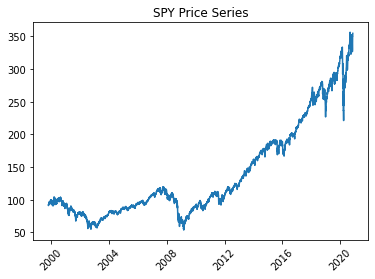

In [370]:
fig = sns.lineplot(x = close_ts.keys(),y = close_ts.values())
fig.set_title(f"{TICKER} Price Series")
plt.xticks(rotation=45)
plt.show()

In [371]:
price = pd.DataFrame.from_dict(close_ts,orient='index',columns=['SPY'])

In [372]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

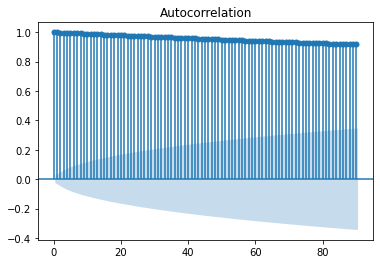

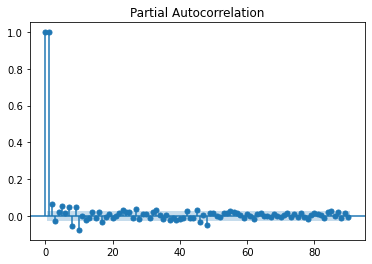

In [373]:
plot_acf(price[TICKER].to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].to_numpy(),lags=90)
plt.show()

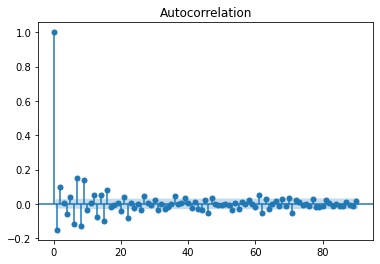

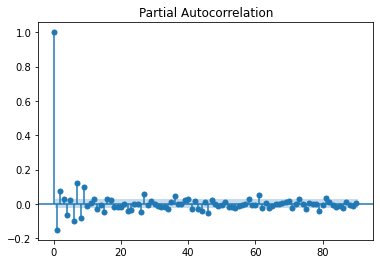

In [376]:
plot_acf(price[TICKER].diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

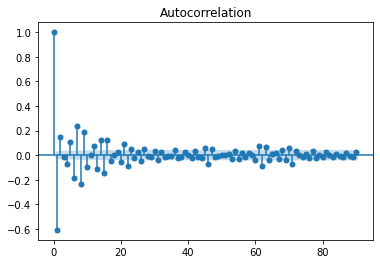

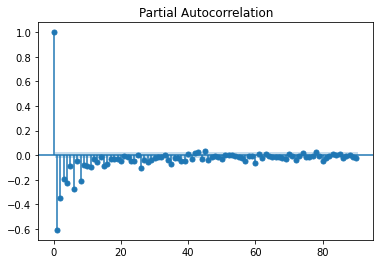

In [377]:
plot_acf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),missing="drop",lags=90,fft=False)
plot_pacf(price[TICKER].diff(periods=-1).diff(periods=-1).dropna().to_numpy(),lags=90)
plt.show()

# Auto-ARIMA

In [482]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [483]:
price = price.sort_index(ascending=True)

In [484]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(price, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(price, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(price, test='pp')  # -> 0

In [485]:
fit = pm.auto_arima(price, start_p=0, start_q=0,
                             max_p=28, start_d=1, max_d=2, max_q=28, seasonal=False,trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True) 

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=25931.051, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=23486.885, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=25929.051, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=22792.144, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=22598.379, Time=0.40 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=22314.485, Time=0.54 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=22275.683, Time=0.73 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=21865.684, Time=0.95 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=21856.721, Time=1.30 sec
 ARIMA(8,2,0)(0,0,0)[0] intercept   : AIC=21619.088, Time=1.61 sec
 ARIMA(9,2,0)(0,0,0)[0] intercept   : AIC=21587.825, Time=2.29 sec
 ARIMA(10,2,0)(0,0,0)[0] intercept   : AIC=21546.789, Time=2.67 sec
 ARIMA(11,2,0)(0,0,0)[0] intercept   : AIC=21495.503, Time=3.37 sec
 ARIMA(12,2,0)(0,0,0)[0

In [489]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5291
Model:              SARIMAX(15, 2, 1)   Log Likelihood              -10573.752
Date:                Mon, 09 Nov 2020   AIC                          21183.504
Time:                        20:21:02   BIC                          21301.825
Sample:                             0   HQIC                         21224.855
                               - 5291                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.544e-05      0.001      0.168      0.867      -0.001       0.001
ar.L1         -0.1160      0.005    -21.344      0.000      -0.127      -0.105
ar.L2          0.0529      0.006      9.565      0.000       0.042       0.064
ar.L3          0.0293      0.006      4.824      0.000       0.017       0.041
ar.L4         -0.0625      0.006    -10.024      0.000      -0.075      -0.050
ar.L5         -0.0063      0.006     -1.029      0.303      -0.018       0.006
ar.L6         -0.0806      0.006    -12.705      0.000      -0.093      -0.068
ar.L7          0.0950      0.007     13.775      0.000       0.081       0.109
ar.L8         -0.0736      0.006    -12.947      0.000      -0.085      -0.062
ar.L9          0.0870      0.007     12.263      0.000       0.073       0.101
ar.L10        -0.0178      0.006     -2.890      0.004      -0.030      -0.006
ar.L11         0.0018      0.007      0.252      0.801      -0.012       0.016
ar.L12         0.0173      0.007      2.326      0.020       0.003       0.032
ar.L13        -0.0376      0.008     -4.973      0.000      -0.052      -0.023
ar.L14        -0.0178      0.008     -2.356      0.018      -0.033      -0.003
ar.L15        -0.0516      0.007     -6.904      0.000      -0.066      -0.037
ma.L1         -0.9803      0.003   -387.466      0.000      -0.985      -0.975
sigma2         3.1827      0.021    153.361      0.000       3.142       3.223
===================================================================================
Ljung-Box (Q):                       95.19   Jarque-Bera (JB):            158055.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.41   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

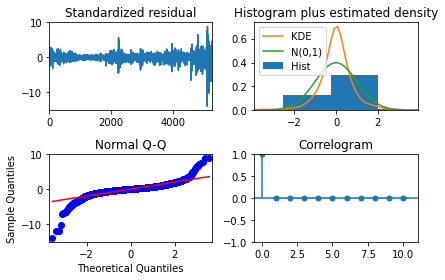

In [490]:
fig = fit.plot_diagnostics()
plt.tight_layout()
plt.show()

Average daily pct change -0.00017714645134760755
Median daily pct change -0.0006948791055709225


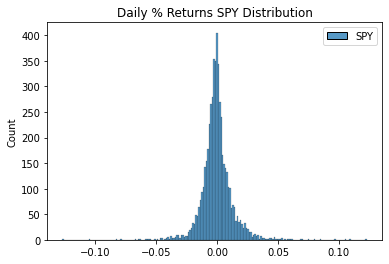

In [491]:
fig = sns.histplot(price.pct_change(-1))
print(f"Average daily pct change {price.pct_change(-1).mean()[0]}")
print(f"Median daily pct change {price.pct_change(-1).median()[0]}")
fig.set_title('Daily % Returns SPY Distribution')
plt.show()

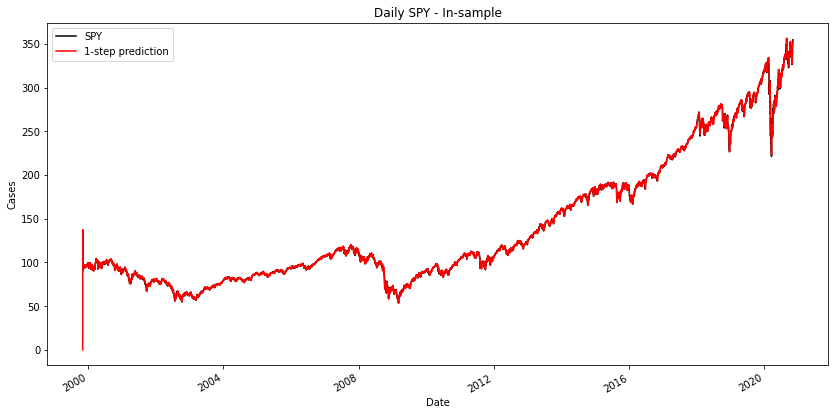

In [507]:
in_sample = fit.predict_in_sample()
pred = pd.DataFrame(in_sample,index=price.index,columns=['1-step prediction'])

ax = price.plot(label='observed', figsize=(14, 7),color='black')
pred.plot(ax=ax, label='forecast',color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.set_title(f"Daily {TICKER} - In-sample")
plt.legend()
plt.show()

In [505]:
steps= 7
future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')
pred_future = pd.DataFrame(fit.predict(n_periods=steps,return_conf_int=False),index=future_index)
pred_future.columns =['predicted']

<ipython-input-505-ddc99777d63e>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  future_index = pd.date_range(start=pd.datetime.now().date(),periods=steps,freq='B')


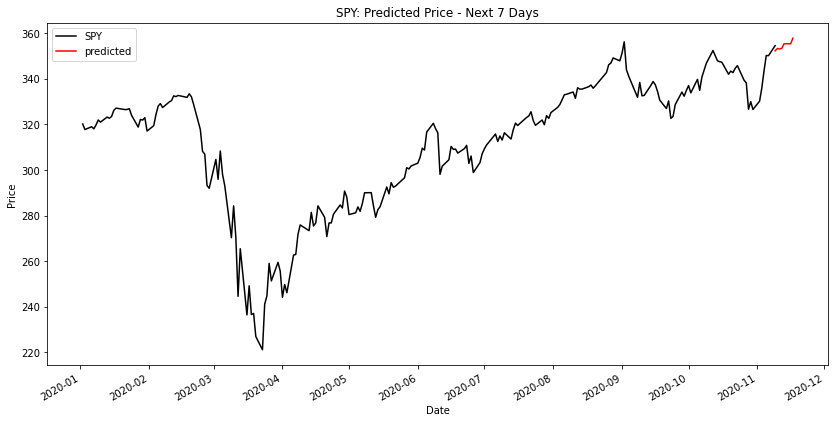

In [506]:
ax = price.loc['2020-01-01':'2020-11-09'].plot(label='observed', figsize=(14, 7),color='black')
pred_future.plot(ax=ax, label='forecast',color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f"{TICKER}: Predicted Price - Next {steps} Days")
plt.legend()
plt.show()

In [502]:
print(f"1 step-ahead forecast for {TICKER}: ${fit.predict(n_periods=1)[0].round(2)}")

1 step-ahead forecast for SPY: $352.29
